In [35]:
!unzip -qq archive_2.zip

replace test/test/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [36]:
import os, shutil, pathlib

original_dir = pathlib.Path("./train/train/")
new_base_dir = pathlib.Path("./cats_vs_dog_5000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=5000)
make_subset("validation", start_index=5000, end_index=5500)
make_subset("test", start_index=5500, end_index=6000)

In [37]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(150, 150),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(150, 150),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(150, 150),
    batch_size=32)

Found 10000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [38]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [39]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [40]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [41]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [42]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


In [43]:
from tensorflow import keras
from tensorflow.keras import layers
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(150, 150, 3))


In [44]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 21ms/step


In [45]:
train_features.shape

(10000, 4, 4, 512)

In [46]:
inputs = keras.Input(shape=(4, 4, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
313/313 [==============================] - 3s 6ms/step - loss: 6.8743 - accuracy: 0.9475 - val_loss: 5.7029 - val_accuracy: 0.9550
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 1.9177 - accuracy: 0.9771 - val_loss: 4.9339 - val_accuracy: 0.9570
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 1.0520 - accuracy: 0.9833 - val_loss: 3.5013 - val_accuracy: 0.9650
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6503 - accuracy: 0.9868 - val_loss: 3.8534 - val_accuracy: 0.9650
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 0.4282 - accuracy: 0.9901 - val_loss: 4.0452 - val_accuracy: 0.9620
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 0.3551 - accuracy: 0.9922 - val_loss: 3.5953 - val_accuracy: 0.9610
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 0.3125 - accuracy: 0.9927 - val_loss: 3.5867 - val_accuracy: 0.9620
Epoch 

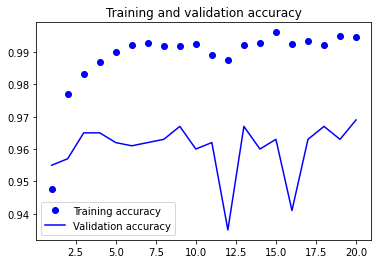

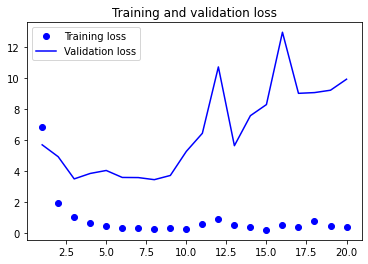

In [47]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [48]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [49]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [50]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [51]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [52]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


313/313 [==============================] - 73s 220ms/step - loss: 6.8400 - accuracy: 0.9233 - val_loss: 3.6526 - val_accuracy: 0.9580
Epoch 2/50
313/313 [==============================] - 67s 212ms/step - loss: 2.5623 - accuracy: 0.9458 - val_loss: 2.0214 - val_accuracy: 0.9650
Epoch 3/50
313/313 [==============================] - 67s 212ms/step - loss: 0.8936 - accuracy: 0.9558 - val_loss: 0.6132 - val_accuracy: 0.9630
Epoch 4/50
313/313 [==============================] - 69s 219ms/step - loss: 0.3279 - accuracy: 0.9584 - val_loss: 0.6054 - val_accuracy: 0.9540
Epoch 5/50
313/313 [==============================] - 68s 216ms/step - loss: 0.2770 - accuracy: 0.9558 - val_loss: 0.3312 - val_accuracy: 0.9670
Epoch 6/50
313/313 [==============================] - 67s 213ms/step - loss: 0.2782 - accuracy: 0.9583 - val_loss: 0.4951 - val_accuracy: 0.9550
Epoch 7/50
313/313 [==============================] - 68s 217ms/step - loss: 0.2882 - accuracy: 0.9611 - val_loss: 0.8059 - val_accuracy: 0.9

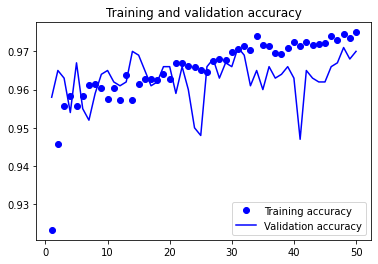

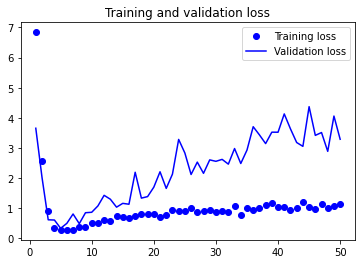

In [55]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [54]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 64ms/step - loss: 0.2616 - accuracy: 0.9720
Test accuracy: 0.972
